In [2]:
! pip install -q kaggle

from google.colab import files

files.upload()

! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets list

Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
ref                                                         title                                           size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
sudarshan24byte/online-food-dataset                         Online Food Dataset                              3KB  2024-03-02 18:50:30          20293        407  0.9411765        
sahirmaharajj/electric-vehicle-population-size-2024         Electric Vehicle Population by Country (2024)  275KB  2024-03-30 19:16:06           1349         37  1.0              
mexwell/drug-consumption-classification                     💊 Drug Consumption Classification               56KB  2024-03-28 15:02:22           1763         35  1.0              
bhavikj

In [3]:
!kaggle datasets download -d atharv1610/terrain-recognition

100% 3.15G/3.16G [00:37<00:00, 50.9MB/s]
100% 3.16G/3.16G [00:37<00:00, 91.1MB/s]


In [4]:
!mkdir terrain-recognition

In [5]:
!unzip terrain-recognition.zip  -d terrain-recognition

Streaming output truncated to the last 5000 lines.
  inflating: terrain-recognition/Data Main/val/Grassy/Grassy (9)_17_0.png  
  inflating: terrain-recognition/Data Main/val/Grassy/Grassy (9)_17_13.png  
  inflating: terrain-recognition/Data Main/val/Grassy/Grassy (9)_17_15.png  
  inflating: terrain-recognition/Data Main/val/Grassy/Grassy (9)_17_19.png  
  inflating: terrain-recognition/Data Main/val/Grassy/Grassy (9)_17_21.png  
  inflating: terrain-recognition/Data Main/val/Grassy/Grassy (9)_17_22.png  
  inflating: terrain-recognition/Data Main/val/Grassy/Grassy (9)_17_23.png  
  inflating: terrain-recognition/Data Main/val/Grassy/Grassy (9)_17_25.png  
  inflating: terrain-recognition/Data Main/val/Grassy/Grassy (9)_17_27.png  
  inflating: terrain-recognition/Data Main/val/Grassy/Grassy (9)_17_31.png  
  inflating: terrain-recognition/Data Main/val/Grassy/Grassy (9)_17_6.png  
  inflating: terrain-recognition/Data Main/val/Grassy/Grassy (9)_17_7.png  
  inflating: terrain-recogni

In [6]:
!pip install tensorflow

In [7]:
!pip install imagehash

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 7.0 MB/s eta 0:00:00


In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
import glob as gb
import pandas as pd
import seaborn as sns
import matplotlib.image as mpimg
import imagehash
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.applications import VGG16
from keras.applications import ResNet101

from keras.applications import EfficientNetB0
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [9]:
train_path = '/content/terrain-recognition/Data Main/train'
test_path = '/content/terrain-recognition/Data Main/test'

In [10]:
from keras.preprocessing.image import ImageDataGenerator
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255,                # Rescale pixel values to [0, 1]
    rotation_range=20,              # Random rotation within 20 degrees
    width_shift_range=0.2,          # Random horizontal shift by 20% of image width
    height_shift_range=0.2,         # Random vertical shift by 20% of image height
    horizontal_flip=True,           # Random horizontal flipping
    fill_mode='nearest'             # Fill mode for new pixels after shifts/rotations
)

In [11]:
size_images = 150
batch_size = 32
train_generator = train_datagen.flow_from_directory(
    train_path,                     # Path to the training data
    target_size=(size_images, size_images),  # Resize images to this size
    batch_size = batch_size,        # Number of images in each batch
    class_mode ='categorical'       # Mode for class labels (categorical for one-hot encoding)
)

Found 31571 images belonging to 4 classes.


In [12]:
test_datagen = ImageDataGenerator(rescale=1.0/255)


In [13]:
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(size_images, size_images),
    batch_size = batch_size,
    class_mode='categorical')

Found 6769 images belonging to 4 classes.


In [14]:
def Show_Images(target_gen):
    # Get a batch of images and labels
    batch_images, batch_labels = next(target_gen)

    # Get class labels
    class_labels = list(target_gen.class_indices.keys())

    # Display images with labels
    plt.figure(figsize=(20, 20))
    for n , i in enumerate(list(np.random.randint(0,len(batch_images),36))):
        plt.subplot(6, 6, n + 1)
        plt.imshow(batch_images[i])
        plt.title(class_labels[np.argmax(batch_labels[i])])  # Display the class label
        plt.axis('off')
    plt.show()


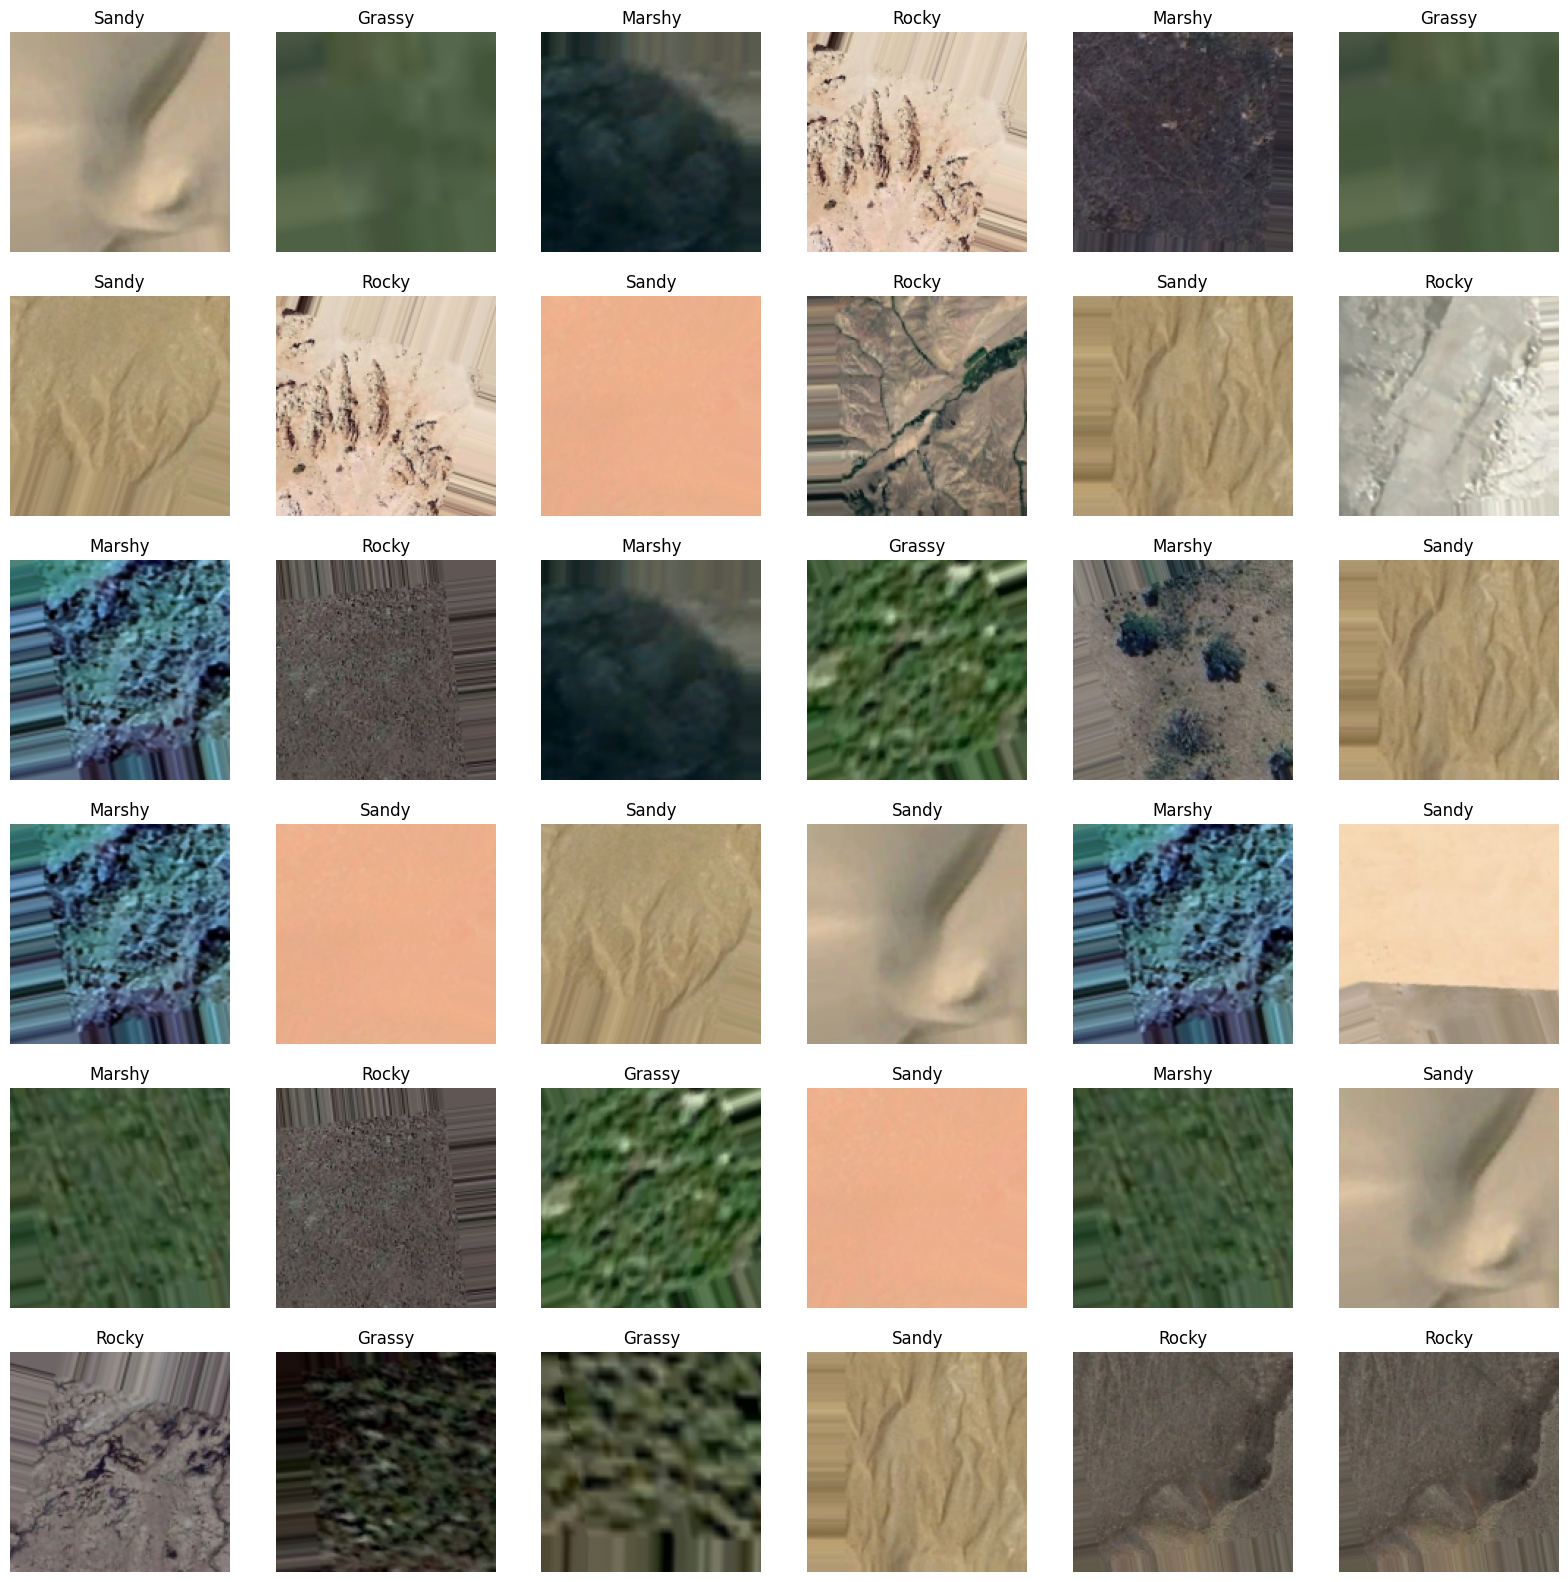

In [15]:
Show_Images(train_generator)

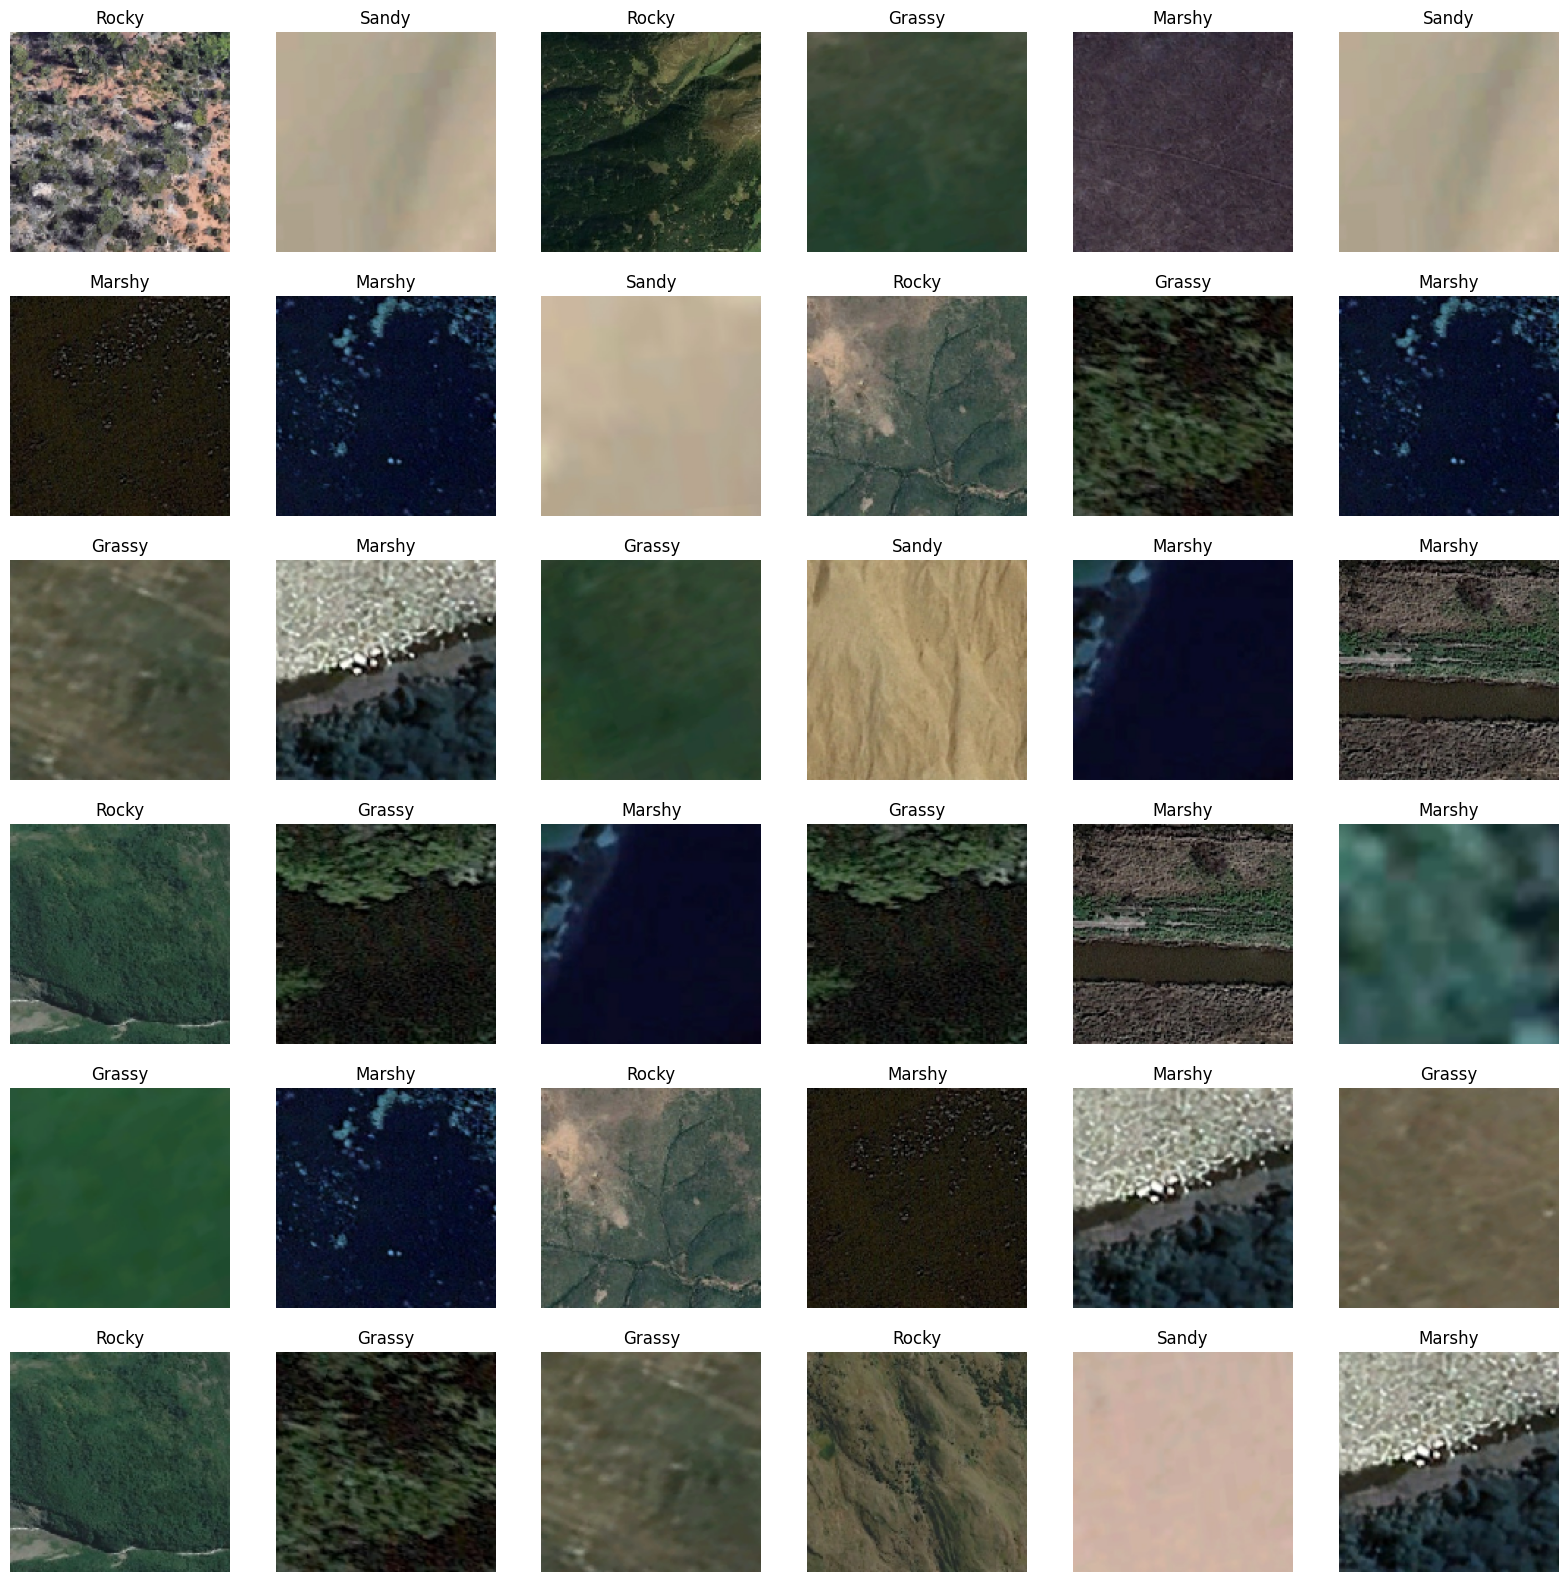

In [16]:
Show_Images(test_generator)


In [17]:
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [18]:
# Configure the learning rate reduction callback
learning_rate_reduce = ReduceLROnPlateau(
    monitor='val_acc',   # Metric to monitor for changes (usually validation accuracy)
    patience=5,          # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1,           # Verbosity mode (0: silent, 1: update messages)
    factor=0.5,          # Factor by which the learning rate will be reduced (e.g., 0.5 means halving)
    min_lr=0.00001       # Lower bound for the learning rate (it won't go below this value)
)

In [19]:
from tensorflow.keras.applications import ResNet101
base_model=ResNet101(weights='imagenet', include_top=False, input_shape=(size_images, size_images, 3))

171446536/171446536 [==============================] - 3s 0us/step


In [20]:
# Freeze the layers of the base model

for layer in base_model.layers:
    layer.trainable = False

In [21]:
from tensorflow.keras import layers
model = tf.keras.models.Sequential([
    base_model,

    layers.Flatten(),

    layers.Dense(256,activation='relu'),
    layers.Dense(128,activation='relu'),
    layers.Dense(64,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(6,activation='softmax'),
])

In [22]:
# Define the parameters for the exponential decay schedule
initial_learning_rate = 0.1     # Initial learning rate
decay_steps = 1000              # Number of steps before decaying the learning rate
decay_rate = 0.5                # Rate at which the learning rate decays
staircase = True                # Whether to use staircase decay (integer division of step by decay_steps)

# Create the exponential decay schedule
def lr_schedule(epoch, lr):
    if staircase:
        return lr * decay_rate ** (epoch // decay_steps)
    else:
        return lr * decay_rate ** (epoch / decay_steps)

In [23]:
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [24]:
# Configure the learning rate reduction callback
learning_rate_reduce = ReduceLROnPlateau(
    monitor='val_acc',   # Metric to monitor for changes (usually validation accuracy)
    patience=5,          # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1,           # Verbosity mode (0: silent, 1: update messages)
    factor=0.5,          # Factor by which the learning rate will be reduced (e.g., 0.5 means halving)
    min_lr=0.00001       # Lower bound for the learning rate (it won't go below this value)
)

In [25]:
from keras.callbacks import LearningRateScheduler

lr_callback = LearningRateScheduler(lr_schedule)
callback=[early_stopping , learning_rate_reduce , lr_callback]

In [26]:
model.compile(optimizer=keras.optimizers.Adam(lr=lr_callback),
             loss="categorical_crossentropy",
              metrics=['accuracy']
             )

In [27]:
from tensorflow.keras.layers import Dense

# Get the model architecture up to the last layer
model = tf.keras.Sequential(model.layers[:-1])

# Add a new output layer for 4 classes
new_output = Dense(4, activation='softmax')  # Assuming 4 classes
model.add(new_output)  # Add the new output layer

# Compile the model again after modifying the architecture
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=20,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    callbacks=[EarlyStopping(patience=3)]
)

Epoch 1/20
986/986 [==============================] - 338s 330ms/step - loss: 1.1497 - accuracy: 0.4582 - val_loss: 0.8139 - val_accuracy: 0.6278
Epoch 2/20
986/986 [==============================] - 320s 325ms/step - loss: 0.8101 - accuracy: 0.6436 - val_loss: 0.7595 - val_accuracy: 0.6407
Epoch 3/20
986/986 [==============================] - 317s 322ms/step - loss: 0.7261 - accuracy: 0.6896 - val_loss: 0.6413 - val_accuracy: 0.7358
Epoch 4/20
986/986 [==============================] - 320s 324ms/step - loss: 0.6850 - accuracy: 0.7123 - val_loss: 0.6717 - val_accuracy: 0.6876
Epoch 5/20
986/986 [==============================] - 332s 337ms/step - loss: 0.6575 - accuracy: 0.7288 - val_loss: 0.5543 - val_accuracy: 0.7773
Epoch 6/20
986/986 [==============================] - 317s 321ms/step - loss: 0.6421 - accuracy: 0.7355 - val_loss: 0.6550 - val_accuracy: 0.7195
Epoch 7/20
986/986 [==============================] - 318s 322ms/step - loss: 0.6190 - accuracy: 0.7453 - val_loss: 0.5508 -

In [29]:
# Evaluate on test dataset
score = model.evaluate(test_generator, verbose=False)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.4805086553096771
Test accuracy: 0.8073570728302002


In [49]:
print(model.input_shape)

(None, 150, 150, 3)


In [53]:
!ls '/content/data/grass.jpg'

/content/data/grass.jpg


In [54]:
!file '/content/data/grass.jpg'

/content/data/grass.jpg: JPEG image data, Exif standard: [TIFF image data, little-endian, direntries=11, description=spring green field, orientation=upper-left, xresolution=166, yresolution=174, resolutionunit=2, software=Adobe Photoshop CC 2015 (Windows), datetime=2017:04:28 16:35:53], baseline, precision 8, 5472x3648, components 3


In [55]:
try:
    import cv2
    img = cv2.imread('/content/data/grass.jpg')
    print(img.shape)
except:
    print('Image file is corrupted')

(3648, 5472, 3)


<Figure size 640x480 with 0 Axes>

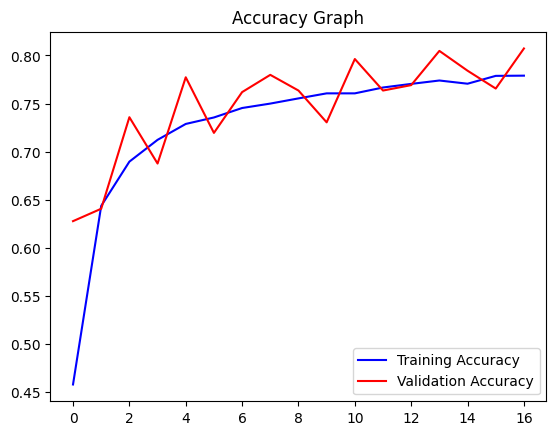

<Figure size 640x480 with 0 Axes>

In [30]:
# Accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

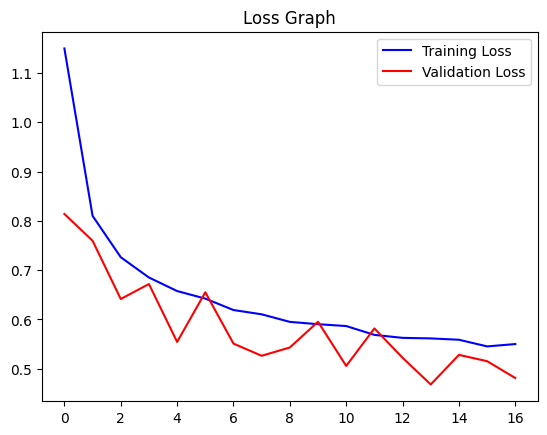

In [31]:
# Loss
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

In [34]:
from tensorflow.keras.models import save_model

# Assuming 'model' is your trained U-Net model
model.save('/content/terrain.h5')


In [39]:
!pip install opencv-python

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from google.colab.patches import cv2_imshow
target_size=(128, 128)

# Function to preprocess input images
def preprocess_image(image, target_size):
    # Resize image
    resized_image = cv2.resize(image, target_size)
    # Normalize pixel values (if needed)
    # normalized_image = resized_image / 255.0  # Example normalization
    return resized_image
# Load the trained U-Net model
loaded_model = load_model('/content/terrain.h5')

# Custom input images directory
custom_images_dir = '/content/data'

# Process each custom input image
for img_name in os.listdir(custom_images_dir):
    # Load and preprocess the input image
    img_path = os.path.join(custom_images_dir, img_name)
    input_image = cv2.imread(img_path)
    cv2_imshow(input_image)
    preprocessed_image = preprocess_image(input_image, target_size=(128, 128))  # Adjust target_size

    # Perform inference
    segmentation_mask = loaded_model.predict(np.expand_dims(preprocessed_image, axis=0))[0]

    # Postprocess segmentation mask (if needed)
    # postprocessed_mask = ...

    # Visualize results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))
    plt.title('Input Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    # Assuming the segmentation mask is binary
    plt.imshow(segmentation_mask.squeeze(), cmap='gray')  # Assuming the mask is single-channel
    plt.title('Segmentation Mask')
    plt.axis('off')

    plt.show()


In [35]:
!mkdir data

In [63]:
import cv2
# !ls /content/data/grassy.jpeg
input_image = cv2.imread("/content/data/grass.jpg")
if input_image is None:
    print("Error: Image not found")
else:
    # Display the image using `cv2_imshow`
    cv2_imshow(input_image)